### Mercedes-Benz Greener Manufacturing.

The Goal of this case study is to reduce the time it takes for each car to undergo testing before it leaves the factory and at the same time the quality shouldn't be compramised.

The error metric of choice here is R^2 -->(Real-Predicted)^2.

The challenge here is that the second dimension of the data is quite large with reference to the first dimenssion (number of columns are high), this leads to curse of dimenssionality.

We will do EDA inorder to eliminate least useful features and also utilize dimenssionality reduction techniques such as PCA, TSNE etc.

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

y_train = df_train['y']

print("shape of train set is:",df_train.shape)
print("shape of test set is:",df_test.shape)

df_train.head()

shape of train set is: (4209, 378)
shape of test set is: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


##### We can see that the features are masked

### 1. Exploratory Data Analysis.
###### References:-
###### https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55 
###### https://www.kaggle.com/deadskull7/78th-place-solution-private-lb-0-55282-top-2

#### 1.1 Distribution of output variable.

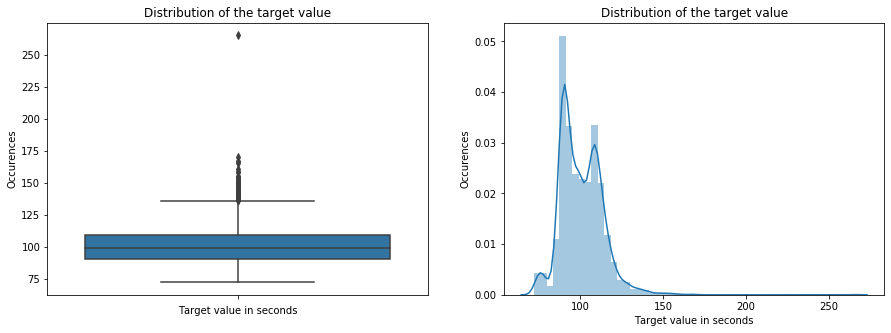

min: 72.11 max: 265.32 mean: 100.66931812782121 std: 12.679381281524675
Count of values above 150: 15


In [3]:
plt.figure(figsize=(15, 5))
plt.figure(1)
plt.subplot(121)
sns.boxplot(y=y_train)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

plt.subplot(122)
sns.distplot(y_train)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

plt.show()

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 150: {}'.format(np.sum(y_train > 150)))

##### From the above distribution of output varirble we can see that most of the values lie between 75-150 seconds.

In [4]:
print((df_train.loc[df_train.y>150,'y'].values))
df_train=df_train[df_train.y<150]
print("Removing outliers based on above information and setting 150 as a threshold value . . . . . . . . . . . . . . . . . . . . ")
print(df_train.shape)
y_train = df_train['y']
print(len(y_train))

[150.43 169.91 154.87 265.32 158.53 154.43 160.87 150.89 152.32 167.45
 154.16 158.23 153.51 165.52 155.62]
Removing outliers based on above information and setting 150 as a threshold value . . . . . . . . . . . . . . . . . . . . 
(4194, 378)
4194


#### 1.2 Feature Analysis

In [5]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

##### From the above cell we can see that the total number of features are 376 out of which 368 are numerical , 8 are categorical and one output variable.
##### Let's see how many of the featutures are constant.

In [6]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 13 Binary features: 355 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X339', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


##### 13 Features are constant and these features can be discarded as they donot add any value to our supervised learning models.

In [7]:
df_test.drop(counts[0],axis=1,inplace=True)
df_train.drop(counts[0],axis=1,inplace=True)

print(df_train.shape)

(4194, 365)


#### 1.2.1 Univariate analysis.

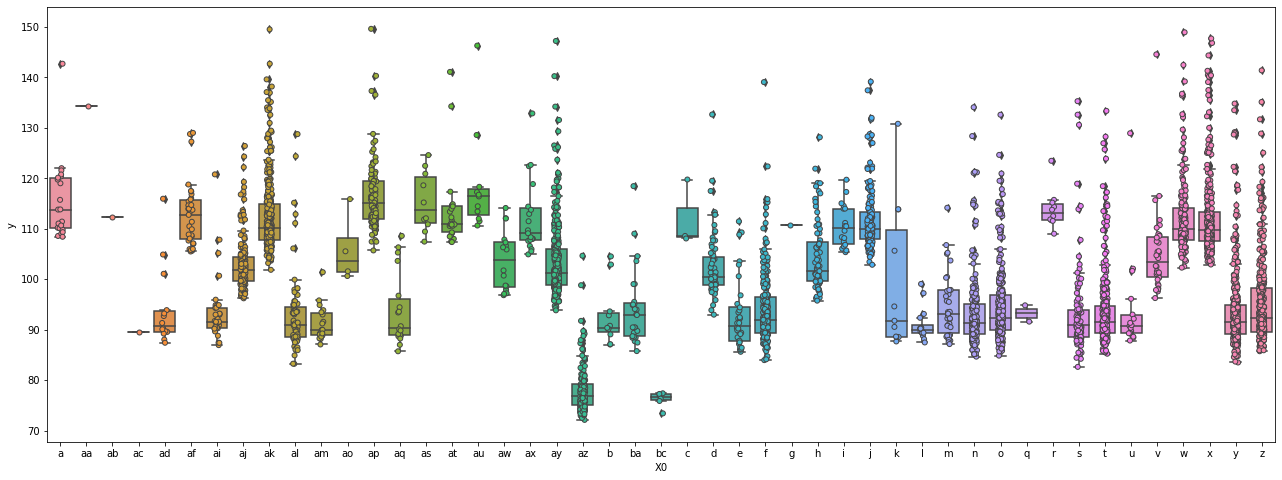

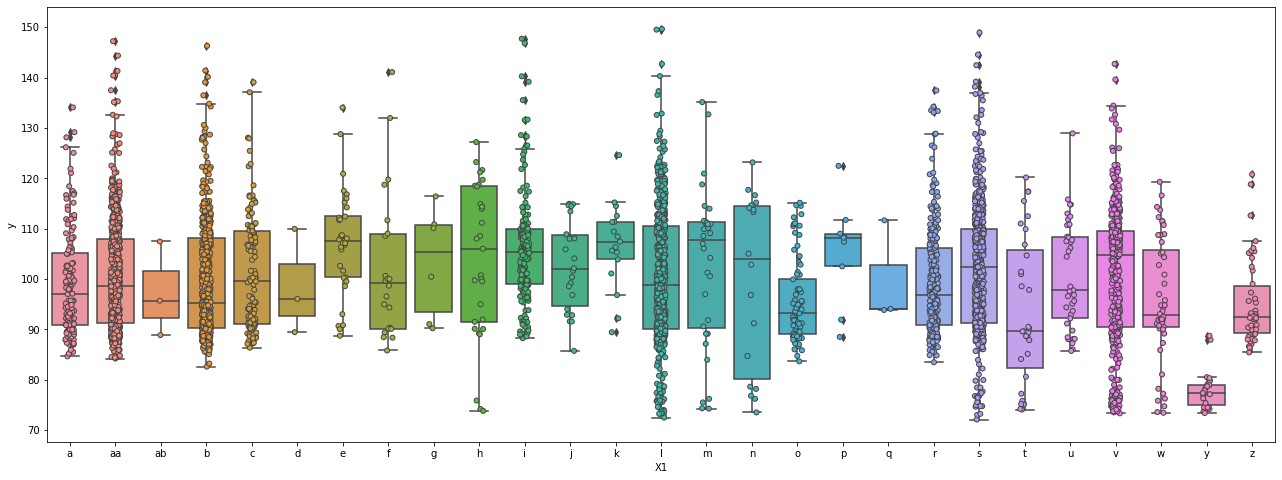

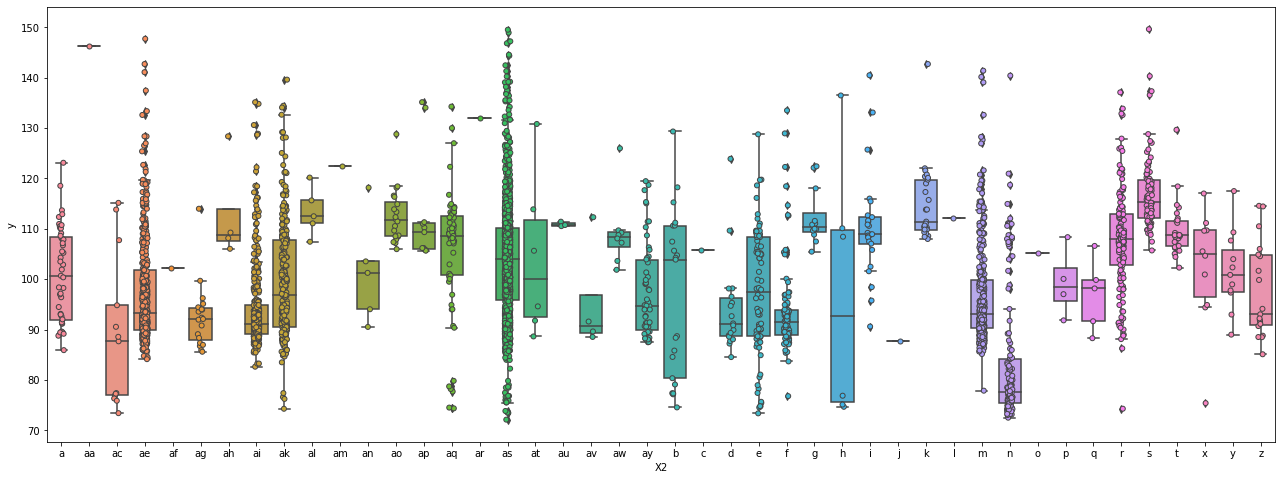

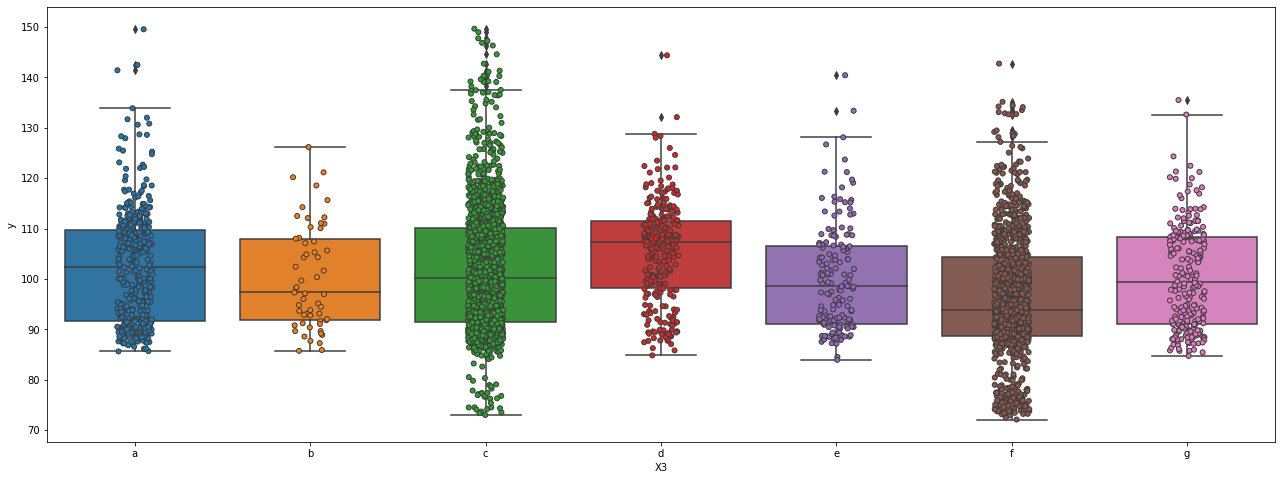

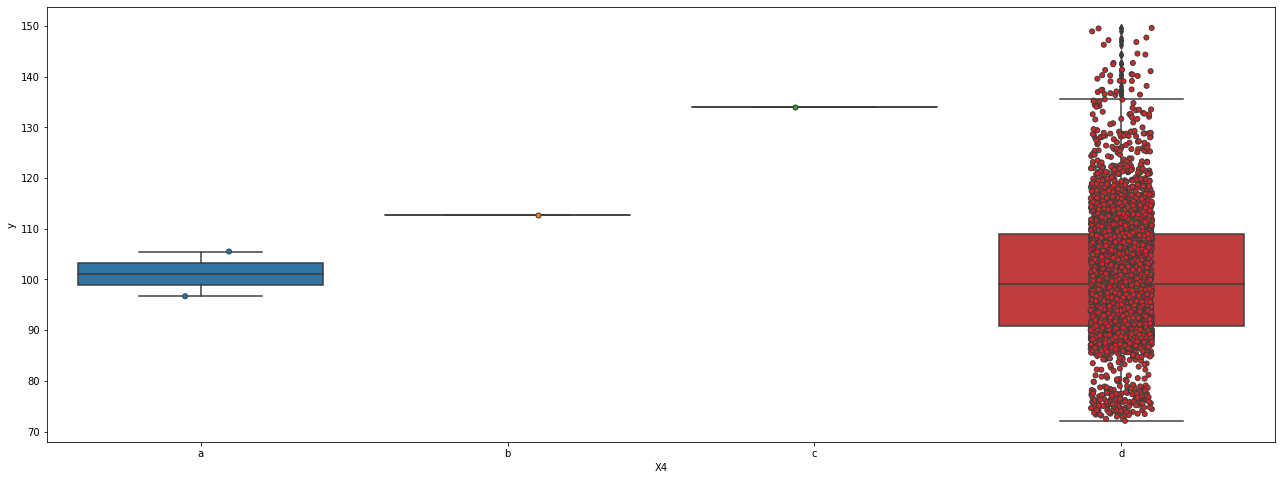

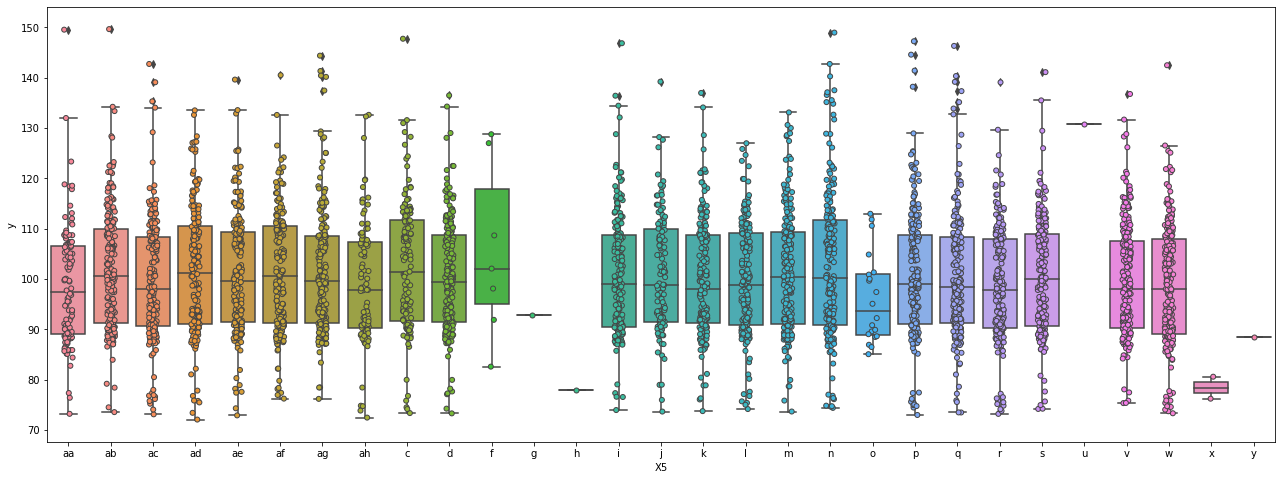

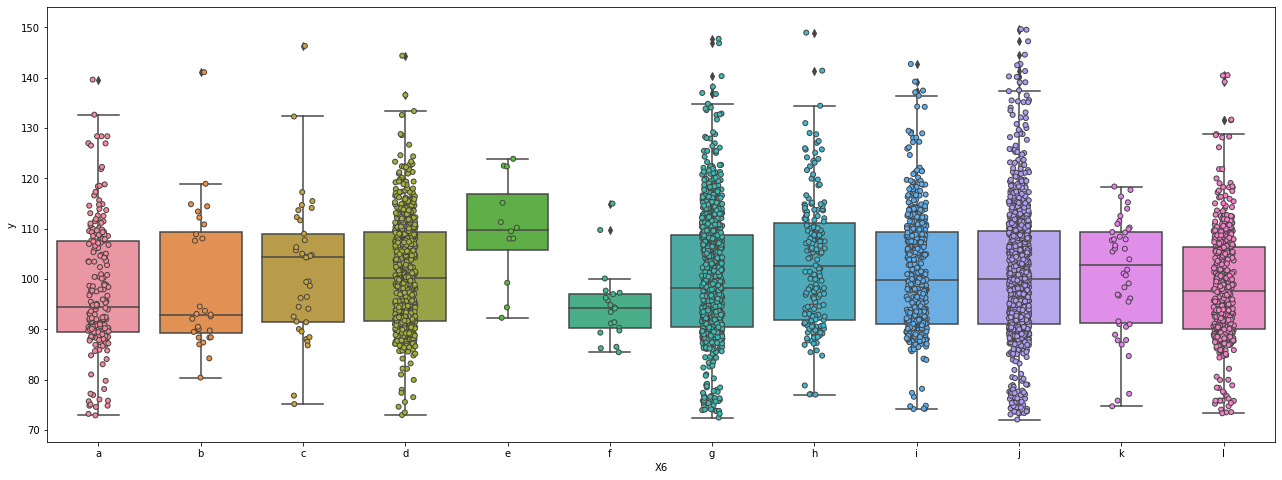

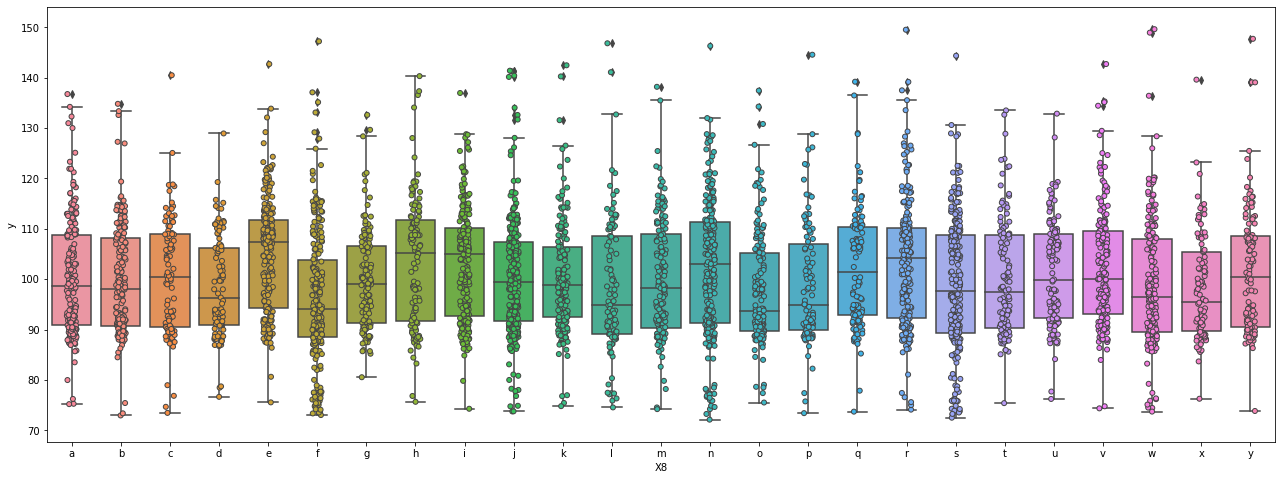

In [8]:
#### Boxplots for categorical features
plt.rcParams['figure.figsize'] = 22, 8
for i in counts[2]:   #counts[2] has all the categorical features
    if i not in 'y':
        plt.figure()
        plt.xlabel=i
        sns.stripplot(x=i, y="y", data=df_train,jitter=True, linewidth=1,order=np.sort(df_train[i].unique()))
        sns.boxplot(x=i, y="y", data=df_train, order=np.sort(df_train[i].unique()))
        plt.show()

#### Observation from the above plots.
1. X0 and X2 are the most useful features as their categories are well distinguished.
2. Categories az and bc from X0, y from X1, n from X2, x and h from X5 are very good indicators of low values of test bech time.
3. Features X3,X5,X6,X8 have similar distruibutions across categories.

#### Checking if ID is a useful feature.

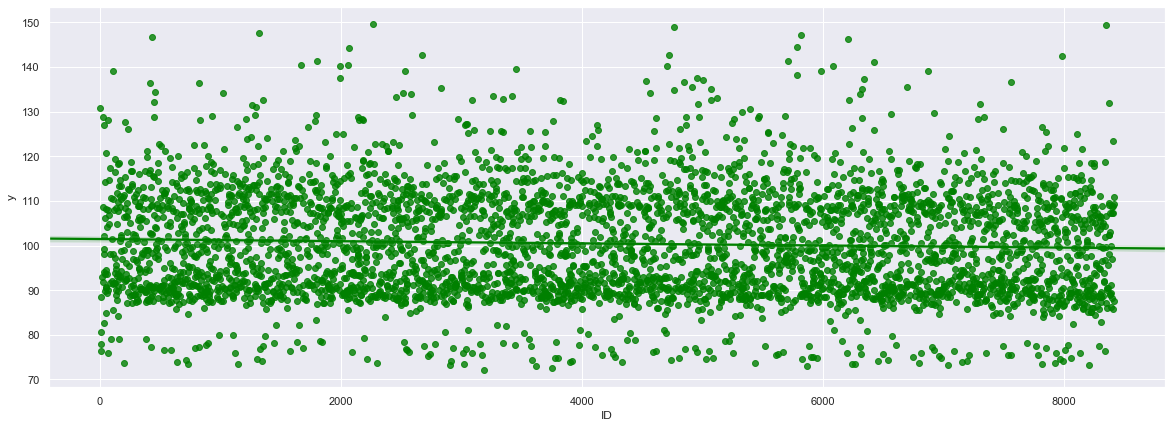

In [8]:
sns.set(rc={'figure.figsize':(20,7)})
sns.regplot(x='ID', y='y', data=df_train,color='green')

##### From the above plot we can see that there is a slight downward trend of output variable 'y' as the ID increases.

#### 1.3 Feature Removal
We have already removed constant features or features with zero variance.


#### 1.3.1 Removing features with very low variance. 
As features which vary for only a few data points are not very useful.

In [8]:
count = 0
low_var_col=[]
for i in counts[1]:
    if df_train[i].var()<0.01:
        low_var_col.append(i)
        count+=1
print(count)

df_train.drop(low_var_col,axis=1,inplace=True)

df_test.drop(low_var_col,axis=1,inplace=True)

135


#### 1.3.2 Removing categorical features which show minimal variation in output variable.
From the box plots it is notable that categorical features X8,X6,X4,X3 are almost indistinguishable acress the categories.

In [9]:
categorical_delete = ['X8','X6','X4','X3']

df_train.drop(categorical_delete,axis=1,inplace=True)
df_test.drop(categorical_delete,axis=1,inplace=True)

print(df_train.shape)
print(df_test.shape)

(4194, 226)
(4209, 225)


#### 1.13.3 Removing duplicate features and features which are very similar to others in the dataframe.
Most of the features in out data are binary features and it makes sense to measure the similarity of each feature so as to potentially emilimate features which are very similar to each other

There are number of similarity measures to be chosen from.

With reference to the paper https://pdfs.semanticscholar.org/3d37/772bbc1823977ee584ecf559f2fdfacf8271.pdf 
Rogers-Tanmoto distance is chosen, it is very similar to Jaccard distance but it uses Bitwise operations.

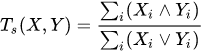

In [10]:
import scipy
pair_distances = {}
def similar_binary_features(df,binary_features):
    '''
    This function takes a dataframe and binary features as inputs
    It calculates the Rogers-Tanmoto diatance between all pairs
    It returns the pairs and their corresponding distances
    '''
    for i in range(len(binary_features)):
        for j in range(i+1,len(binary_features)):
            distance = scipy.spatial.distance.rogerstanimoto(df[binary_features[i]],df[binary_features[j]])
            pair_distances[(binary_features[i],binary_features[j])] = distance
    return pair_distances
            



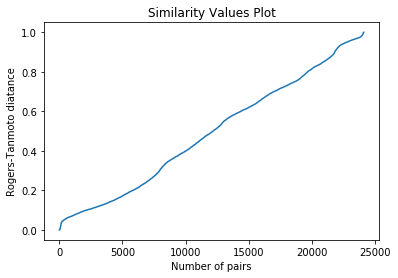

In [11]:
binary_features = [i for i in counts[1] if i not in low_var_col]
pair_similarity = similar_binary_features(df_train,binary_features)
result = sorted(list(pair_similarity.values()))

plt.title("Similarity Values Plot")
plt.ylabel("Rogers-Tanmoto diatance")
plt.xlabel("Number of pairs")
plt.plot(result)

#### From the above plot we can see that there is no obvious Knee point however the graph hence we shall analyze all duplicate pairs.

In [12]:
similar_pairs = []
for key,value in pair_similarity.items():
    if value < 0.006:
        similar_pairs.append(key)
print(similar_pairs)

[('X19', 'X215'), ('X29', 'X54'), ('X29', 'X76'), ('X29', 'X162'), ('X29', 'X232'), ('X29', 'X279'), ('X29', 'X328'), ('X31', 'X35'), ('X31', 'X37'), ('X35', 'X37'), ('X44', 'X302'), ('X48', 'X113'), ('X48', 'X134'), ('X48', 'X147'), ('X48', 'X198'), ('X48', 'X222'), ('X49', 'X129'), ('X54', 'X76'), ('X54', 'X162'), ('X54', 'X232'), ('X54', 'X279'), ('X58', 'X324'), ('X71', 'X84'), ('X71', 'X244'), ('X76', 'X162'), ('X76', 'X232'), ('X76', 'X279'), ('X80', 'X348'), ('X84', 'X244'), ('X108', 'X371'), ('X113', 'X134'), ('X113', 'X147'), ('X113', 'X198'), ('X113', 'X222'), ('X118', 'X119'), ('X126', 'X264'), ('X134', 'X147'), ('X134', 'X198'), ('X134', 'X222'), ('X136', 'X263'), ('X138', 'X140'), ('X138', 'X146'), ('X140', 'X146'), ('X147', 'X198'), ('X147', 'X222'), ('X152', 'X226'), ('X152', 'X326'), ('X155', 'X360'), ('X162', 'X232'), ('X162', 'X279'), ('X185', 'X378'), ('X198', 'X222'), ('X202', 'X247'), ('X208', 'X368'), ('X226', 'X326'), ('X232', 'X279'), ('X232', 'X328'), ('X279', 

In [13]:
print(len(similar_pairs))
remove_cols = []
for pair in similar_pairs:
    if pair[0] not in remove_cols and pair[1] not in remove_cols:
        remove_cols.append(pair[1])
print(remove_cols)
print(len(remove_cols))

df_train.drop(remove_cols,axis=1,inplace=True)

df_test.drop(remove_cols,axis=1,inplace=True)

59
['X215', 'X54', 'X76', 'X162', 'X232', 'X279', 'X328', 'X35', 'X37', 'X302', 'X113', 'X134', 'X147', 'X198', 'X222', 'X129', 'X324', 'X84', 'X244', 'X348', 'X371', 'X119', 'X264', 'X263', 'X140', 'X146', 'X226', 'X326', 'X360', 'X378', 'X247', 'X368', 'X352']
33


In [14]:
print(df_train.shape)
df_test.shape

(4194, 193)


(4209, 192)

In [15]:
from sklearn import preprocessing
categorical=[]
mapper = lambda x: sum([ord(digit) for digit in x])
for i in df_train.columns:
    if df_train[i].dtype=='object':
        df_train[i] = df_train[i].apply(mapper)
        df_test[i] = df_test[i].apply(mapper)
df_train.head()
df_test.head()

,ID,X0,X1,X2,X5,X10,X12,X13,X14,X19,...,X359,X361,X362,X363,X367,X373,X374,X375,X376,X377
0,1,219,118,110,116,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,2,116,98,202,98,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
2,3,219,118,212,97,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,4,219,108,110,122,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,5,119,115,212,121,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0


In [16]:
train_y = df_train['y']
df_train.drop(['y'],axis=1,inplace=True)

train_X = df_train

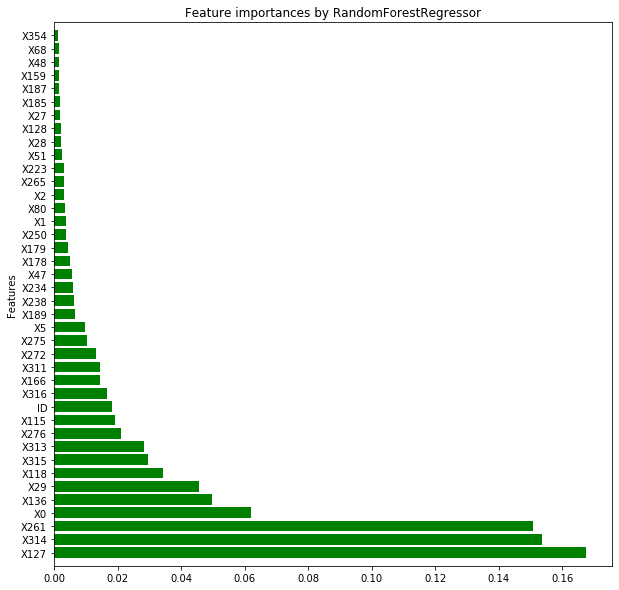

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feature_names = train_X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:40]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Feature Importance by XGBoost


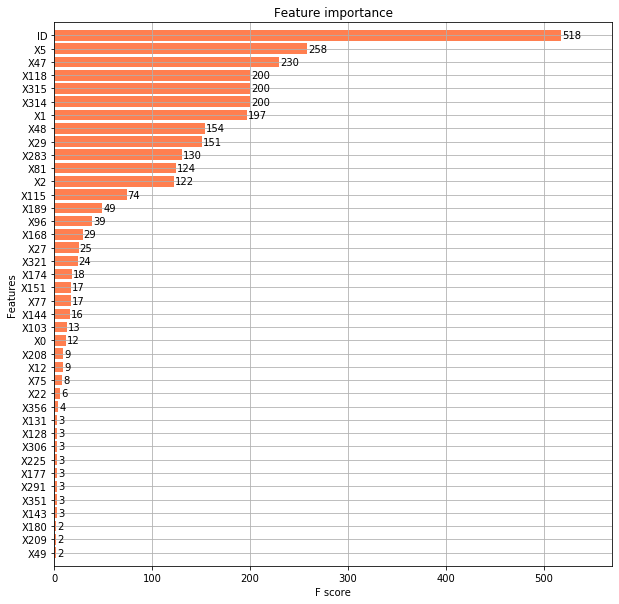

In [18]:
import xgboost as xgb

def xgb_r2_score(preds, final):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'n_trees': 520, 
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.98,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': np.mean(train_y), # base prediction = mean(target)
    'silent': 1
}

final = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params), final, num_boost_round=200, feval=xgb_r2_score, maximize=True)

fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=40, height=0.8, ax=ax, color = 'coral')
print("Feature Importance by XGBoost")
plt.show()

#### From the above polts we can see that the feature importance given by the two models are very different from each other.
#### We can also observe that 'X0' which has shown good variation in our Box-Plots doesnot perform as well as we thought it would.

#### 1.4 Feature Engineering.


#### 1.4.1 'X0' clustering
From the box-plots of categorical features we can see that the feature 'X0' can be used to cluster the points into different groups hence we shall incorporate this feature.

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score,cross_val_predict

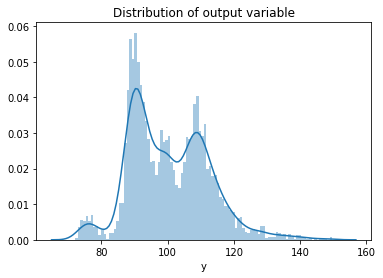

In [18]:
plt.title("Distribution of output variable")
sns.distplot(train_y,bins=100)

#### We shall cluster the dataset into 4 clusters using the group mean of output variable of each category.

In [19]:
#https://www.kaggle.com/daniel89/mercedes-cars-clustering/
'''
This class takes in a dataframe, fits the KMeans model on train data and transforms it on train and test data
and returns the feature lables 
'''
class cluster_target_encoder:
    def __init__(self,nclusters=4,seed=0):
        self.seed= seed
        self.nclusters= nclusters
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean() #this will return the mean of output variable grouped by category
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'],index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters,random_state=self.seed)
        #self.encoding[df['X'].values].values--> this will return the mean value of the output variable for each datapoint based on its category
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
    def transform(self,X):
        #X.map(self.clust_encoding).astype(float)--> this will return the group mean as output variable for the category input
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

Populating the interactive namespace from numpy and matplotlib


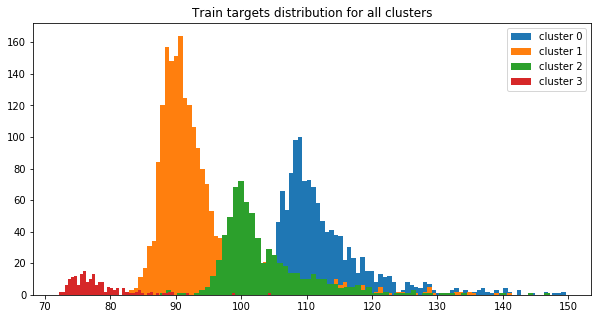

In [20]:
enc1 = cluster_target_encoder()
labels_train = enc1.fit_transform(df_train['X0'],train_y)
labels_test = enc1.transform(df_test['X0'])
%pylab inline
plt.figure(figsize(10,5))
plt.hist(train_y.values[labels_train==0],bins=70,label='cluster 0')
plt.hist(train_y.values[labels_train==1],bins=100,label='cluster 1')
plt.hist(train_y.values[labels_train==2],bins=70,label='cluster 2')
plt.hist(train_y.values[labels_train==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
#plt.xlim((60,170))
plt.show()

#### From the above plot we can see that although there is an overlap between the clusters majority of them are well distinguished.


In [21]:
#to check if the test lables have any NAN values(this occues when the test set has new categories which are not in train set)
labels_test[np.isnan(labels_test)].shape

(5,)

##### To predict the lables of the datapoints which have an unseen category we can use another model by giving numerical columns as input and train_lables as output trian the model and use this to predict the lables of 5 Nan rows in test.

In [22]:
est = xgb.XGBClassifier()
est.fit(df_train.select_dtypes(include=[np.number]),labels_train)
labels_test[np.isnan(labels_test)] = est.predict(df_test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]
np.isnan(labels_test).any()

False

[20:55:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


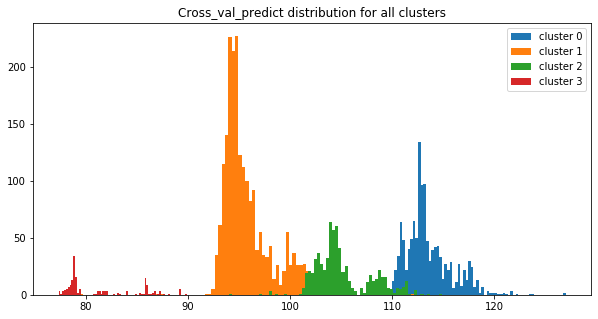

In [23]:
y_pred = cross_val_predict(
    X = df_train,
    y = train_y,
    estimator = xgb.XGBRegressor(),
    cv = 5)
plt.figure(figsize(10,5))
plt.hist(y_pred[labels_train==0],bins=70,label='cluster 0')
plt.hist(y_pred[labels_train==1],bins=100,label='cluster 1')
plt.hist(y_pred[labels_train==2],bins=70,label='cluster 2')
plt.hist(y_pred[labels_train==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Cross_val_predict distribution for all clusters')
plt.show()

#### The above plot shows us that the new feature added can cluster the dataset into 4 groups 

#### 1.4.2 Feature Learner
We shall take all the numerical columns(binary) and form pairs or triplets of them and find the sum of these pairs/triplets
The new feature will be assessed based on it corellation with the output variable.
The features with highest corellation will be added as new features to our dataset.

In order to compare a contineous variable(output) and a categorical/binary variable we wil use Point-Biserial correlation coefficient.
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

In [ ]:
'''
This snippet takes pairs/triplets of features from the dataset and sums them inorder to form a new feature.
The pointbiserial corellation between the new feature and output variable is calculated and stored in feature_dict 
'''
from scipy.stats import pointbiserialr 
cols = df_train.columns[5:]
feature_dict = {}
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        feature = df_train[cols[i]] + df_train[cols[j]]
        if feature.any()>2:
            print("Not binary")
        corelation = pointbiserialr(feature,train_y)
        feature_dict[cols[i] + '+' + cols[j]] = corelation[0]
        for k in range(j+1,len(cols)):
            feature = df_train[cols[i]] + df_train[cols[j]] + df_train[cols[k]]
            if feature.any()>2:
                print("Not binary")
            corelation = pointbiserialr(feature,train_y)
            feature_dict[cols[i] + '+' + cols[j] + '+' + cols[k]] = corelation[0]

In [27]:
len(feature_dict)

1089836

In [28]:
for key,value in feature_dict.items():
    if value > 0.73 or value < -0.73:
        print(key)
        print(value)

X29+X127+X166
-0.7366678230095592
X29+X127+X272
-0.7411032213321457
X29+X127+X276
-0.7435651925352641
X127+X272+X276
-0.7316775411532012
X136+X261+X315
0.7311818599794854
X136+X314+X315
0.7469051211149618


In [24]:
#adding new useful features to the dataset.
df_train['X29+X127+X276'] = df_train['X29'] + df_train['X127'] + df_train['X276']
df_train['X136+X314+X315'] = df_train['X136'] + df_train['X314'] + df_train['X315']
df_train['X136+X179+X261'] = df_train['X136'] + df_train['X179'] + df_train['X261']

df_test['X29+X127+X276'] = df_test['X29'] + df_test['X127'] + df_test['X276']
df_test['X136+X314+X315'] = df_test['X136'] + df_test['X314'] + df_test['X315']
df_test['X136+X179+X261'] = df_test['X136'] + df_test['X179'] + df_test['X261']

In [25]:
train_X = df_train
train_X['labels']=labels_train
df_test['labels']=labels_test

print(train_X.shape)
print(df_test.shape)

(4194, 196)
(4209, 196)


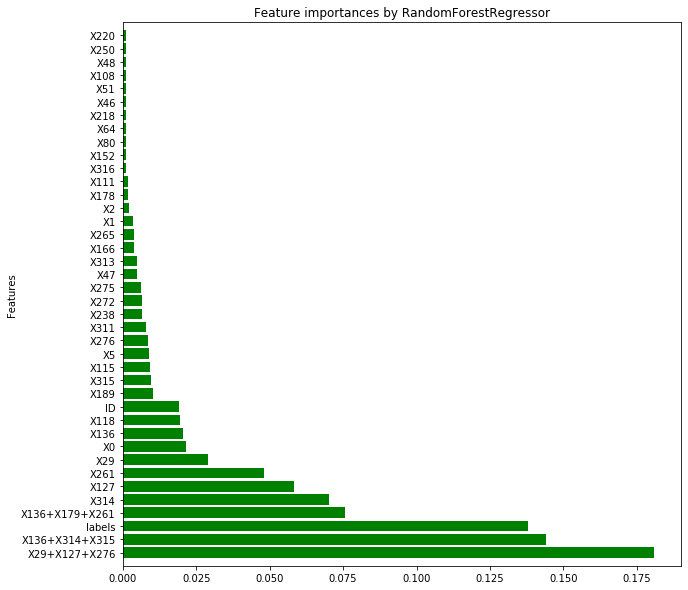

In [26]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feature_names = train_X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:40]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

Feature Importance by XGBoost


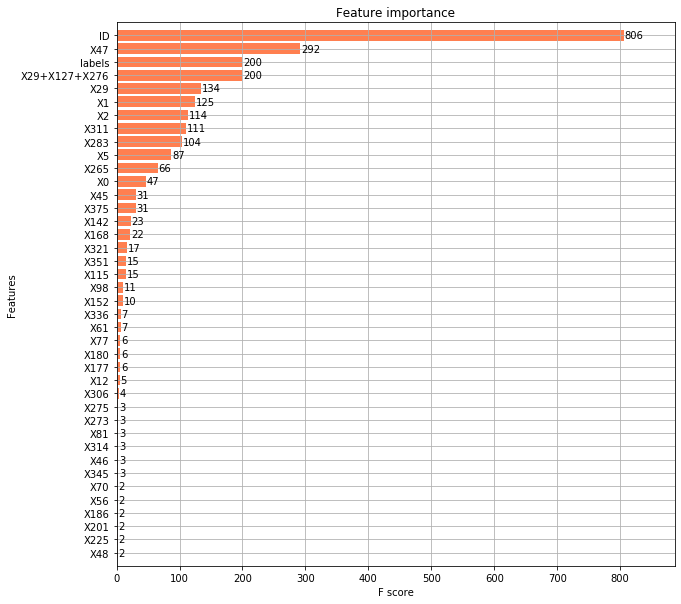

In [27]:
import xgboost as xgb

def xgb_r2_score(preds, final):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'n_trees': 520, 
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.98,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': np.mean(train_y), # base prediction = mean(target)
    'silent': 1
}

final = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params), final, num_boost_round=200, feval=xgb_r2_score, maximize=True)

fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=40, height=0.8, ax=ax, color = 'coral')
print("Feature Importance by XGBoost")
plt.show()

#### From the above plots we can see that the new features are few of the most important features in both Random Forest and XGBoost models.

###  2. Modelling and Hyper-Parameter Tuning.

#### 2.1 Linear Regression.

In [28]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=-1)
reg.fit(train_X, train_y)
preds = reg.predict(train_X)

def score(preds, actual_y):
    return 'r2', r2_score(actual_y, preds)
result = score(preds,train_y)
print(result)

('r2', 0.6476908426436685)


##### From the above cell we can see that Linear regression gives a r2_score of 0.6476, this can be considered as a baseline for models to follow.

#### 2.2 Random Forest Regressor.

In [93]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(random_state=42)
parameters = {'max_depth':(2,3,4,5,6,8,10), 'n_estimators':[50,100,200,250,300,350,400,500],'min_samples_leaf':[2,4,6,10],
             'max_features':[0.2,0.3,0.4,0.5]}
clf = GridSearchCV(model, parameters, scoring='r2', n_jobs=-1, verbose=1)
clf.fit(train_X, train_y)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 896 candidates, totalling 2688 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2688 out of 2688 | elapsed: 13.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': (2, 3, 4, 5, 6, 8

In [95]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 50}
0.6194706408147459


In [96]:
model = RandomForestRegressor(max_depth= 4, max_features= 0.5, min_samples_leaf= 4, n_estimators= 50,random_state=42)
model.fit(train_X, train_y)
preds = model.predict(train_X)
result = score(preds,train_y)
print(result)

('r2', 0.6389670399318518)


##### From the above cell we can see that Random Forest doesnot perform very well when compared to the baselie model this might be due to the large dimensionallity of the data we have.

#### 2.3 XGBoost Regressor.

#### 2.3.1 Tuning max_depth

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=420)

Text(0.5, 1.0, 'R2 score for train set vs validation set')

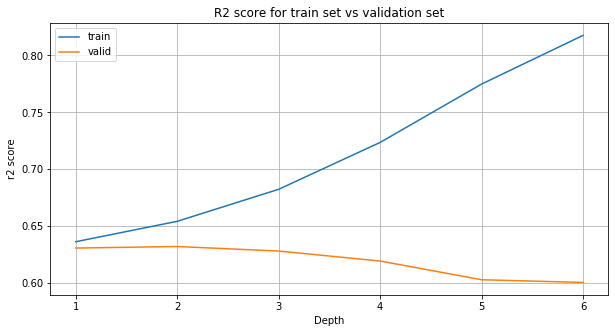

In [30]:
train_depth = []
valid_depth = []
depth = [1,2,3,4,5,6]
for i in (depth):
    model2 = xgb.XGBRegressor(subsample=0.95,eta=0.0050,
                                         max_depth=i,base_score=np.mean(train_y),silent=1,seed=42)
    model2.fit(x_train, y_train)
    
    preds = model2.predict(x_train)
    result = score(preds,y_train)
    train_depth.append(result[1])
    
    preds = model2.predict(x_valid)
    result = score(preds,y_valid)
    valid_depth.append(result[1])

plt.plot(depth,train_depth,label='train')
plt.plot(depth,valid_depth,label='valid')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('r2 score')
plt.grid()
plt.title('R2 score for train set vs validation set')

#### From the above plot we can see that lower depths (range of 1-3) will yeild the best results.

#### 2.3.2 Tuning number of trees

Text(0.5, 1.0, 'R2 score for train set vs validation set')

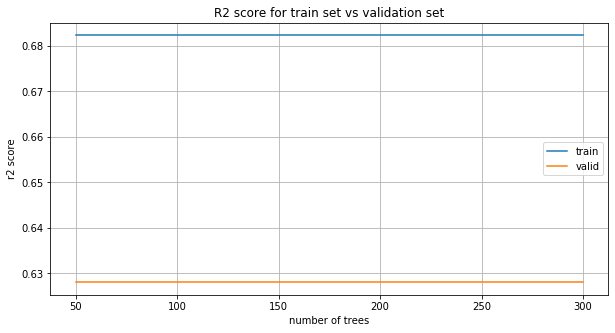

In [31]:
train_trees = []
valid_trees = []
trees = [50,100,150,200,250,300]
for i in (trees):
    model2 = xgb.XGBRegressor(subsample=0.95,eta=0.0050,
                                         max_depth=3,n_trees=i,base_score=np.mean(train_y),silent=1,seed=42)
    model2.fit(x_train, y_train)
    
    preds = model2.predict(x_train)
    result = score(preds,y_train)
    train_trees.append(result[1])
    
    preds = model2.predict(x_valid)
    result = score(preds,y_valid)
    valid_trees.append(result[1])

plt.plot(trees,train_trees,label='train')
plt.plot(trees,valid_trees,label='valid')
plt.legend()
plt.grid()
plt.xlabel('number of trees')
plt.ylabel('r2 score')
plt.title('R2 score for train set vs validation set')

#### From the above graph we can see that the score remais constant with change of number of trees this might change with change in other parameters.

#### 2.3.2 Tuning gamma.

Text(0.5, 1.0, 'R2 score for train set vs validation set')

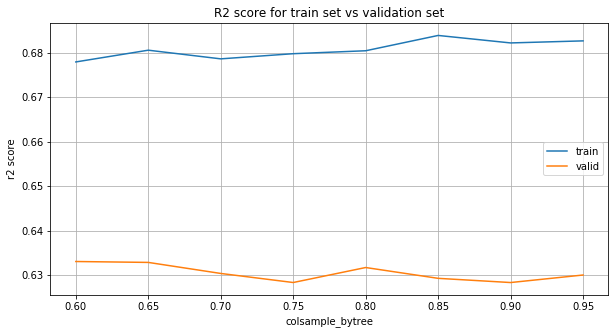

In [32]:
train_sample = []
valid_sample = []
sample = [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]
for i in (sample):
    model2 = xgb.XGBRegressor(subsample=0.95,eta=0.0050,colsample_bytree=i,
                                         max_depth=3,n_trees=50,base_score=np.mean(train_y),silent=1,seed=42)
    model2.fit(x_train, y_train)
    
    preds = model2.predict(x_train)
    result = score(preds,y_train)
    train_sample.append(result[1])
    
    preds = model2.predict(x_valid)
    result = score(preds,y_valid)
    valid_sample.append(result[1])

plt.plot(sample,train_sample,label='train')
plt.plot(sample,valid_sample,label='valid')
plt.legend()
plt.grid()
plt.xlabel('colsample_bytree')
plt.ylabel('r2 score')
plt.title('R2 score for train set vs validation set')

#### From the above graph we can see that the lower values of colsample_bytree yeild better scores on validation set.

#### 2.3.2 Tuning number of colsample_bytree

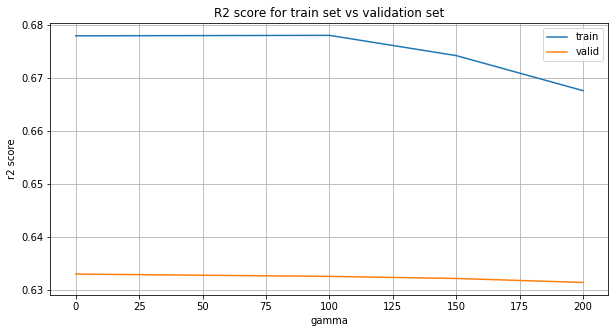

In [33]:
train_gamma = []
valid_gamma = []
gamma = [0,100,150,200]
for i in (gamma):
    model2 = xgb.XGBRegressor(subsample=0.95,eta=0.0050,colsample_bytree=0.6,gamma=i,
                                         max_depth=3,n_trees=50,base_score=np.mean(train_y),silent=1,seed=42)
    model2.fit(x_train, y_train)
    
    preds = model2.predict(x_train)
    result = score(preds,y_train)
    train_gamma.append(result[1])
    
    preds = model2.predict(x_valid)
    result = score(preds,y_valid)
    valid_gamma.append(result[1])

plt.xlabel('gamma')
plt.ylabel('r2 score')
plt.title('R2 score for train set vs validation set')
plt.grid()
plt.plot(gamma,train_gamma,label='train')
plt.plot(gamma,valid_gamma,label='valid')
plt.legend()

#### From the above graph we can see that gamma is best left at 0.

#### 3. Final Models.

#### 3.1 Fitting on 80% of train data and validating on 20%.

In [34]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=420)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(df_test)

xgb_params = {
    'n_trees': 50, 
    'eta': 0.0050,
    'max_depth': 3,
    'subsample': 0.95,
    'colsample_bytree': 0.6,
    'eval_metric': 'rmse',
    'base_score': np.mean(train_y), # base prediction = mean(target)
    'silent': 1
}

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(xgb_params, d_train, 1050 , watchlist, early_stopping_rounds=150, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:11.9881	valid-rmse:11.8275	train-r2:0.006163	valid-r2:0.005898
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 150 rounds.
[10]	train-rmse:11.6288	valid-rmse:11.4709	train-r2:0.064838	valid-r2:0.064926
[20]	train-rmse:11.2941	valid-rmse:11.1392	train-r2:0.117905	valid-r2:0.118223
[30]	train-rmse:10.9794	valid-rmse:10.8268	train-r2:0.166381	valid-r2:0.167
[40]	train-rmse:10.6867	valid-rmse:10.5366	train-r2:0.210221	valid-r2:0.211044
[50]	train-rmse:10.4135	valid-rmse:10.2664	train-r2:0.250094	valid-r2:0.250989
[60]	train-rmse:10.1592	valid-rmse:10.0153	train-r2:0.286264	valid-r2:0.287181
[70]	train-rmse:9.92392	valid-rmse:9.78338	train-r2:0.318946	valid-r2:0.319816
[80]	train-rmse:9.70526	valid-rmse:9.56736	train-r2:0.348628	valid-r2:0.349523
[90]	train-rmse:9.5034	valid-rmse:9.36854	train-r2:0.375442	valid-r2:0.376276
[100]	train-rmse:9.31646	valid-rmse:9.18384	train-r2:0.399771	valid-r2:0.

[1020]	train-rmse:7.05326	valid-rmse:7.18591	train-r2:0.655972	valid-r2:0.633046
[1030]	train-rmse:7.0502	valid-rmse:7.18617	train-r2:0.65627	valid-r2:0.633019
[1040]	train-rmse:7.04736	valid-rmse:7.18595	train-r2:0.656547	valid-r2:0.633041
[1049]	train-rmse:7.04471	valid-rmse:7.18624	train-r2:0.656805	valid-r2:0.633012


#### 3.2 Fitting on full train data.

In [35]:
d_train = xgb.DMatrix(train_X, label=train_y)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
#d_test = xgb.DMatrix(df_test)

xgb_params = {
    'n_trees': 50, 
    'eta': 0.0050,
    'max_depth': 3,
    'subsample': 0.95,
    'colsample_bytree': 0.6,
    'eval_metric': 'rmse',
    'base_score': np.mean(train_y), 
    'silent': 1
}

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'),(d_valid, 'valid')]

clf = xgb.train(xgb_params, d_train, 1050 , watchlist, early_stopping_rounds=70, feval=xgb_r2_score, maximize=True, \
                verbose_eval=10)

[0]	train-rmse:11.9561	valid-rmse:11.8274	train-r2:0.006197	valid-r2:0.0059
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 70 rounds.
[10]	train-rmse:11.5962	valid-rmse:11.4691	train-r2:0.06512	valid-r2:0.06522
[20]	train-rmse:11.2597	valid-rmse:11.1343	train-r2:0.118596	valid-r2:0.119001
[30]	train-rmse:10.9473	valid-rmse:10.8238	train-r2:0.166829	valid-r2:0.167462
[40]	train-rmse:10.66	valid-rmse:10.5376	train-r2:0.209978	valid-r2:0.210906
[50]	train-rmse:10.4023	valid-rmse:10.2811	train-r2:0.247715	valid-r2:0.248846
[60]	train-rmse:10.1483	valid-rmse:10.0287	train-r2:0.284008	valid-r2:0.285273
[70]	train-rmse:9.91587	valid-rmse:9.79768	train-r2:0.31643	valid-r2:0.317826
[80]	train-rmse:9.69902	valid-rmse:9.58215	train-r2:0.346002	valid-r2:0.347509
[90]	train-rmse:9.49756	valid-rmse:9.38221	train-r2:0.372888	valid-r2:0.374455
[100]	train-rmse:9.31131	valid-rmse:9.19758	train-r2:0.397243	valid-r2:0.3988

[1020]	train-rmse:7.06877	valid-rmse:7.01957	train-r2:0.652617	valid-r2:0.649837
[1030]	train-rmse:7.06583	valid-rmse:7.01703	train-r2:0.652906	valid-r2:0.650091
[1040]	train-rmse:7.06264	valid-rmse:7.01448	train-r2:0.653219	valid-r2:0.650345
[1049]	train-rmse:7.05994	valid-rmse:7.01114	train-r2:0.653484	valid-r2:0.650678


In [37]:
import pickle
#saving model to disk
file = 'best_model.sav'
pickle.dump(clf,open(file, 'wb'))

In [45]:
test_preds = clf.predict(d_test)

submission = pd.DataFrame()
submission['ID'] = df_test.ID
submission['y'] = test_preds
submission.to_csv('Mercedes_Benz_Self_case_study_version2.csv',index=False)

In [67]:
submission.head()

,ID,y
0,1,81.744415
1,2,105.267708
2,3,81.738800
3,4,80.133232
4,5,119.389458


In [68]:
submission.shape

(4209, 2)

In [47]:
feats_to_drop = ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X339', 'X347']+\
                low_var_col + categorical_delete + remove_cols

In [49]:
np.save('feats_to_drop.npy',feats_to_drop)

### Conclusion.
1. Selection of features/ removal of less important features boosted the score significantly.
2. Additional features which were added by feature engineering proved to be very useful.

score attaind by the best model is shown below

Total participants- 3826
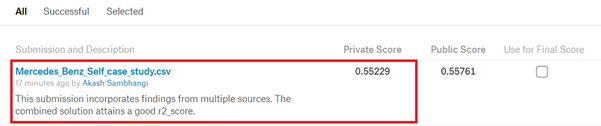
The score lies in Top 4% of the Leaderboard solutions.

Here is a snapshot of the leaderboard 
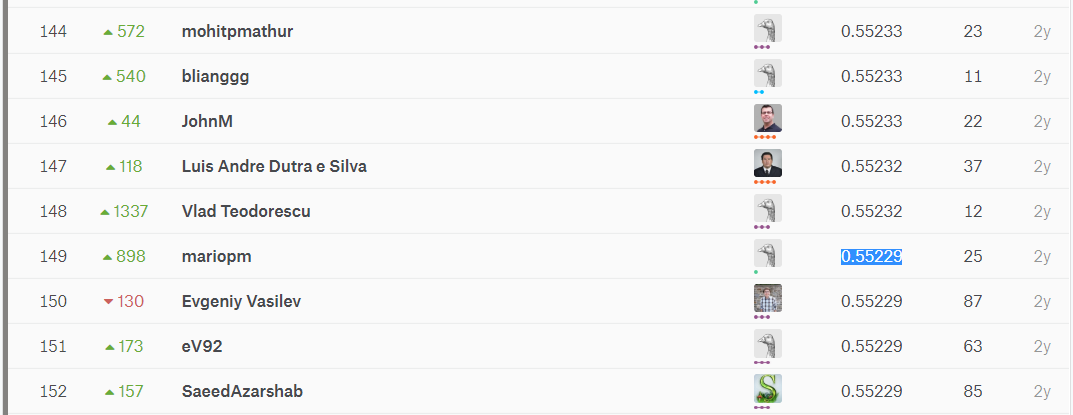